In [1]:
import os, sys
import feather
import re
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# project_dir = os.path.dirname(os.path.dirname(os.path.abspath(os.path.curdir)))
project_dir = os.path.dirname(os.path.abspath(os.path.curdir))
new_path = os.path.join(project_dir, 'src')
sys.path.append(new_path)

import util as u
from model import pipeline as p

pd.options.display.max_columns = 100

/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
full_df = feather.read_dataframe('../data/processed/train_df.feather')

In [6]:
full_df.shape

(7449443, 27)

In [3]:
full_df['label'].value_counts(1)

benign      0.998858
phishing    0.001142
Name: label, dtype: float64

In [5]:
# take subset of data for initial model assessment
df = full_df.sample(frac=0.2).reset_index(drop=True)

In [37]:
df.shape

(1489889, 33)

In [38]:
len(df.dropna())

274694

Discovered that a few entries had empty URL's -- remove these

In [39]:
len(df.dropna(subset=['url']))

1489888

In [40]:
df = df.dropna(subset=['url'])

(1489888, 33)

In [41]:
# Make sure we've retained proportion of labels
df['label'].value_counts(1)

benign      0.998868
phishing    0.001132
Name: label, dtype: float64

In [6]:
del full_df

Convert int to float64

In [42]:
int_cols = df.select_dtypes(include='int').columns
int_cols = [col for col in int_cols if re.search('_ind', col) is None]

for col in int_cols:
    df[col] = df[col].astype(np.float64)

From EDA: Correlated features:
- length_url with length_path, url_X_cnt, and url_entropy
    - convert to fraction

In [43]:
cols_to_convert = ['length_path', 'length_domain', 'url_slash_cnt',
       'url_digit_cnt', 'url_special_char_cnt', 'url_reserved_char_cnt']

for col in cols_to_convert:
    new_col_name = col + '_frac_url_len'
    df[new_col_name] = df[col] / df['length_url']

In [12]:
# def extract_base_suffix(s):
#     if len(s) > 0:
#         return s.split('.')[0]
#     else:
#         return s

# df['base_suffix'] = df['suffix'].apply(extract_base_suffix)

### Split into X, y and a further train-test

In [44]:
target = 'label'
X = df.drop(columns=target)
y = df[target]

enc = LabelEncoder()
y_enc = enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.25)

# Preprocessing

In [18]:
all_cols = df.columns

target = 'label'

proc_dict = {
#     'base_suffix':[p.Consolidate(1), OneHotEncoder(handle_unknown='ignore')]
            }

num_cols = [col for col in all_cols if re.search('_cnt', col) is not None] + \
            ['length_url', 'hostname_entropy', 'url_entropy']

bool_cols = [col for col in all_cols if re.search('_ind', col) is not None]

pass_thru_cols = [col for col in all_cols if re.search('_frac_url_len', col) is not None]

for col in num_cols:
    proc_dict[col] = [StandardScaler()]

for col in bool_cols + pass_thru_cols:
    proc_dict[col] = [p.PassThrough()]

Do not include suffix, as benign only contains '.com', so this is a leaky variable of sorts

In [ ]:
model_cols = ['subdomain_null_ind', 'subdomain_www_ind', 'length_url',
              'domain_dot_cnt', 'path_dot_cnt', 'hostname_dash_cnt',
              'hostname_entropy', 'url_entropy', 'php_ind',
              'admin_ind', 'verification_ind', 'length_path_frac_url_len',
              'length_domain_frac_url_len', 'url_slash_cnt_frac_url_len',
              'url_digit_cnt_frac_url_len', 'url_special_char_cnt_frac_url_len',
              'url_reserved_char_cnt_frac_url_len']

In [19]:
preproc_pipe = FeatureUnion(p.gen_pipeline(model_cols, proc_dict))

# Tune Random Forest

As the algorithm took ~10 min to fit-predict one iteration, 3- to 5-fold cross validation inside a `GridSearchCV` would be time prohibitive. We'll use a train-test-split of our subset of our train data (so, we are still sufficiently protected from out hold-out test set), and perform tuning "by hand".

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

In [45]:
X_train_proc = preproc_pipe.fit_transform(X_train, y_train)
X_test_proc = preproc_pipe.transform(X_test)

Test out our code, while tweaking a hyperparamter (`min_impurity_decrease`):

In [56]:
model = RandomForestClassifier(n_estimators=100, min_impurity_decrease=0.001)
start_time = time.time()
print('Fitting model....')
model.fit(X_train_proc, y_train)
print('Predicting test...')
y_pred_test = model.predict(X_test_proc)
print('Test score: ', f1_score(y_test, y_pred_test))
y_pred_train = model.predict(X_train_proc)
print('Train score: ', f1_score(y_train, y_pred_train))

duration = time.time() - start_time
print('Elapsed time: {:.0f} seconds'.format(duration))

Fitting model....
Predicting test...


/Users/kendra/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test score:  0.0
Train score:  0.0
Elapsed time: 45 seconds


/Users/kendra/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
def compare_train_test(model):    
    start_time = time.time()
    print('Fitting model....')
    model.fit(X_train_proc, y_train)
    print('Predicting test...')
    y_pred_test = model.predict(X_test_proc)
    print('Test score: ', f1_score(y_test, y_pred_test))
    y_pred_train = model.predict(X_train_proc)
    print('Train score: ', f1_score(y_train, y_pred_train))

    duration = time.time() - start_time
    print('Elapsed time: {:.0f} seconds'.format(duration))
    return model

## Criterion

In [58]:
base_rf = compare_train_test(RandomForestClassifier(n_estimators=100, max_depth=10, criterion='gini'))

Fitting model....
Predicting test...
Test score:  0.08482142857142858
Train score:  0.12658227848101267
Elapsed time: 314 seconds


In [59]:
rf2 = compare_train_test(RandomForestClassifier(n_estimators=100, max_depth=10, criterion='entropy'))

Fitting model....
Predicting test...
Test score:  0.20545073375262055
Train score:  0.257617728531856
Elapsed time: 329 seconds


Entropy is an improvement

## Max depth of trees

In [60]:
rf3 = compare_train_test(RandomForestClassifier(n_estimators=100, max_depth=5, criterion='entropy'))

Fitting model....
Predicting test...
Test score:  0.018518518518518517
Train score:  0.017336485421591805
Elapsed time: 182 seconds


In [61]:
rf4 = compare_train_test(RandomForestClassifier(n_estimators=100, max_depth=8, criterion='entropy'))

Fitting model....
Predicting test...
Test score:  0.07640449438202247
Train score:  0.1321455085374907
Elapsed time: 247 seconds


In [62]:
rf5 = compare_train_test(RandomForestClassifier(n_estimators=150, max_depth=10, criterion='entropy'))

Fitting model....
Predicting test...
Test score:  0.20545073375262055
Train score:  0.26482758620689656
Elapsed time: 437 seconds


In [63]:
rf6 = compare_train_test(RandomForestClassifier(n_estimators=100, max_depth=9, criterion='entropy'))

Fitting model....
Predicting test...
Test score:  0.16702355460385437
Train score:  0.22065063649222064
Elapsed time: 264 seconds


In [64]:
rf7 = compare_train_test(RandomForestClassifier(n_estimators=100, max_depth=12, criterion='entropy'))

Fitting model....
Predicting test...
Test score:  0.25254582484725047
Train score:  0.3490813648293963
Elapsed time: 333 seconds


By now, I can make a plot of results. If I had to do this over, I'd have generated & collected the data more programatically

In [100]:
depths = [5, 8, 9, 10, 12]
res_test = [0.018518518518518517, 0.07640449438202247, 0.16702355460385437, 0.20545073375262055, 0.25254582484725047]
res_train = [0.017336485421591805, 0.1321455085374907, 0.22065063649222064, 0.257617728531856, 0.3490813648293963]

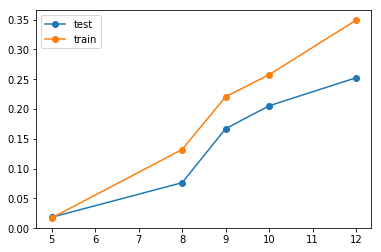

In [103]:
plt.plot(depths, res_test, label='test', marker='o')
plt.plot(depths, res_train, label='train', marker='o')
plt.legend()

### Overfitting!

What if we eliminate the restriction on `max_depth`?

In [65]:
rf7 = compare_train_test(RandomForestClassifier(n_estimators=100, criterion='entropy'))

Fitting model....
Predicting test...
Test score:  0.34980988593155893
Train score:  0.9919935948759007
Elapsed time: 413 seconds


In [88]:
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

3769

In [92]:
node_depth

array([0, 1, 2, ..., 3, 4, 4])

In [93]:
max(node_depth)

37

In [94]:
def get_tree_depth(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
    
    return max(node_depth)

In [95]:
max_depths = [get_tree_depth(est) for est in rf7.estimators_]

In [97]:
import matplotlib.pyplot as plt

(array([ 2., 12., 20., 27.,  9., 12.,  7.,  6.,  4.,  1.]),
 array([30. , 31.8, 33.6, 35.4, 37.2, 39. , 40.8, 42.6, 44.4, 46.2, 48. ]),
 <a list of 10 Patch objects>)

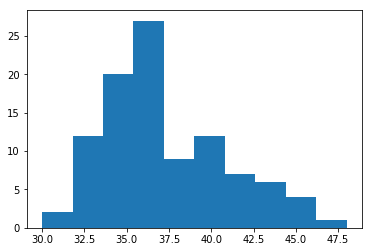

In [98]:
plt.hist(max_depths)

In [105]:
depths = [5, 8, 9, 10, 12, 35]
res_test = [0.018518518518518517, 0.07640449438202247, 0.16702355460385437, 0.20545073375262055, 0.25254582484725047,
           0.34980988593155893]
res_train = [0.017336485421591805, 0.1321455085374907, 0.22065063649222064, 0.257617728531856, 0.3490813648293963,
            0.9919935948759007]

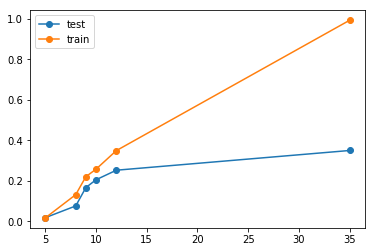

In [106]:
plt.plot(depths, res_test, label='test', marker='o')
plt.plot(depths, res_train, label='train', marker='o')
plt.legend()

Now that's overfitting!

## n_estimators

In [108]:
rf8 = compare_train_test(RandomForestClassifier(n_estimators=75, max_depth=10, criterion='entropy'))

Fitting model....
Predicting test...
Test score:  0.19789473684210523
Train score:  0.2636300897170462
Elapsed time: 217 seconds


In [115]:
depths = [5, 8, 9, 10, 12]
res_test = [0.018518518518518517, 0.07640449438202247, 0.16702355460385437, 0.20545073375262055, 
            0.25254582484725047]
res_train = [0.017336485421591805, 0.1321455085374907, 0.22065063649222064, 0.257617728531856, 
             0.3490813648293963]

In [116]:
depth_75 = [10]
res_test_75 = [0.19789473684210523,]
res_train_75 = [0.2636300897170462]

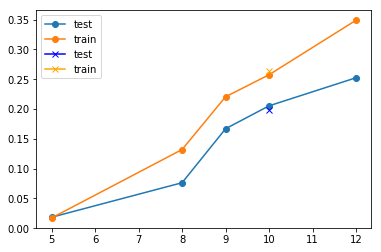

In [117]:
plt.plot(depths, res_test, label='test', marker='o')
plt.plot(depths, res_train, label='train', marker='o')
plt.plot(depth_75, res_test_75, label='test', marker='x', color='blue')
plt.plot(depth_75, res_train_75, label='train', marker='x', color='orange')

plt.legend()

Could have investigated reducing the number of estimators even further